In [132]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [133]:
!pip install folium

In [2]:
import numpy as np
import pandas as pd
import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# backend for rendering plots within the browser
%matplotlib inline 
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

import folium

# Part 1 - route exploration

First, I import a csv file with the coordinates of the route points from Krakow to Rome

In [7]:
route_df = pd.read_csv('fromKRAKOWtoROME.csv') 
route_df.head()

Latitude  Longitude    point
0  50.06187   19.93680   RPT001
1  50.06201   19.93632   RPT002
2  50.06140   19.93577   RPT003
3  50.06063   19.93764   RPT004
4  50.05464   19.93850   RPT005

I check the number of route points

In [9]:
route_df.shape

(2397, 3)

I am preparing Krakow's coordinates to start drawing a map

In [101]:
address = 'Cracow, Poland'
geolocator = Nominatim(user_agent="cracow_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cracow are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Cracow are 46.1410878, 12.9076867.


Draw a map with route points

In [100]:
map_route = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, in zip(route_df['Latitude'], route_df['Longitude']):    
    
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_route)  
    
map_route


Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'ANIQGQPQYO3LFX0STDDM23OR0OD3VPZ2PBU0SGYWW41IX41K' # your Foursquare ID
CLIENT_SECRET = 'D5OW3BNSVQU5YKELSUPW0ZCSGOIAJRU3JKPDXOPSNZJERTFY' # your Foursquare Secret
ACCESS_TOKEN = 'A5W0UKQ4QR00GJZAE4EP45P5DRBCKUNEQ34FFRGGICYRKVPC' # your FourSquare Access Token
VERSION = '20180604'

For the selected route point (n for example 1750) we will find monuments, food and accommodation in the area defined by the given radius

In [52]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 8000 # define radius

#Foursquare Venue Category:
sightseeing ='4deefb944765f83613cdba6e'or'4bf58dd8d48988d190941735'
food = '4d4b7105d754a06374d81259'
accommodation = '4bf58dd8d48988d1fa931735'


In [53]:
n = 1750 #point number on the route
latitude = route_df['Latitude'][n]
longitude = route_df['Longitude'][n]

In [54]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [55]:
#finding places to visit
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    sightseeing)

results = requests.get(url).json()

In [56]:
venues1 = results['response']['groups'][0]['items']

df_sightseeing = pd.json_normalize(venues1) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_sightseeing =df_sightseeing.loc[:, filtered_columns]
# filter the category for each row
df_sightseeing['venue.categories'] = df_sightseeing.apply(get_category_type, axis=1)
# clean columns
df_sightseeing.columns = [col.split(".")[-1] for col in df_sightseeing.columns]
df_sightseeing.head()

name     categories        lat        lng
0  Palazzo Del Vignola  Historic Site  44.604799  11.348963
1       La Grotta 1570  Historic Site  44.547189  11.351965
2        Rocca Isolani  Historic Site  44.623295  11.490487

In [57]:
#finding places to eat
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    food)

results = requests.get(url).json()

In [58]:
venues2 = results['response']['groups'][0]['items']

df_food = pd.json_normalize(venues2) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_food =df_food.loc[:, filtered_columns]
df_food['venue.categories'] = df_food.apply(get_category_type, axis=1)
df_food.columns = [col.split(".")[-1] for col in df_food.columns]
df_food.head()

name            categories        lat        lng
0          La Scuderia    Italian Restaurant  44.572880  11.375412
1  Trattoria del Gallo    Italian Restaurant  44.559714  11.394200
2       Villa La Torre    Italian Restaurant  44.604116  11.356408
3   Piadina sbarazzina  Fast Food Restaurant  44.589166  11.368166
4           Villa Orsi    Italian Restaurant  44.589528  11.374251

In [59]:
#finding accommodation
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    accommodation)

results = requests.get(url).json()

In [60]:
venues3 = results['response']['groups'][0]['items']

df_accommodation = pd.json_normalize(venues3) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_accommodation =df_accommodation.loc[:, filtered_columns]
df_accommodation['venue.categories'] = df_accommodation.apply(get_category_type, axis=1)
df_accommodation.columns = [col.split(".")[-1] for col in df_accommodation.columns]
df_accommodation.head()

name categories        lat        lng
0  Ramada Encore Hotel Bologna Fiera      Hotel  44.533210  11.367620
1             Imperial Hotel Bologna      Hotel  44.533344  11.370654
2                      Hotel Marconi      Hotel  44.594178  11.383175
3                  B&B Hotel Bologna      Hotel  44.559101  11.376876
4                      Hotel Nettuno      Hotel  44.559086  11.376791

Drawing a map showing the location of the found places for the selected point. 

Monuments marked in red, food in orange, and accommodation in green. Blue are waypoints.

In [61]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map

for lat, lng, in zip(route_df['Latitude'], route_df['Longitude']):    
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(venues_map)  


folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='blue',
    
    fill = True,
    fill_color = 'blue',
    fill_opacity = 0.6
).add_to(venues_map)

#Historic paces on red
for lat, lng, label in zip(df_sightseeing.lat, df_sightseeing.lng, df_sightseeing.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)

#food on orange    
for lat, lng, label in zip(df_food.lat, df_food.lng, df_food.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.6
    ).add_to(venues_map)

#accomodation on green
for lat, lng, label in zip(df_accommodation.lat, df_accommodation.lng, df_accommodation.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Monuments marked in red, food in orange, and accommodation in green. Blue are waypoints.

# Part 2 - Sightseeing in Rome

Determining the coordinates of Rome

In [62]:
address = 'Roma, Italy'
geolocator = Nominatim(user_agent="rome_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rome are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Rome are 41.8933203, 12.4829321.


I set up my search criteria on Fouresquare for monuments within 4 km

In [64]:
search = 'Monument'
LIMIT = 100 
radius = 4000 
#category = '4deefb944765f83613cdba6e' #category id for Historic Site

Preparing the URL address and downloading the result

In [65]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    search,
#    category,
)
results = requests.get(url).json()

Filter the results

In [66]:
venues = results['response']['groups'][0]['items']
    
dataframe = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
dataframe =dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe['venue.categories'] = dataframe.apply(get_category_type, axis=1)

# clean columns
dataframe.columns = [col.split(".")[-1] for col in dataframe.columns]

dataframe

name           categories        lat  \
0                        Piazza Venezia                Plaza  41.895747   
1                   Altare della Patria  Monument / Landmark  41.895042   
2                              Pantheon  Monument / Landmark  41.899133   
3                            Vittoriano  Monument / Landmark  41.895440   
4   Zuil van Trajanus (Colonna Traiana)  Monument / Landmark  41.895816   
..                                  ...                  ...        ...   
95                 Obelisco Sallustiano  Monument / Landmark  41.906088   
96                      Campo de' Fiori                Plaza  41.895702   
97                    Villa Celimontana                 Park  41.884662   
98                     Piazza di Spagna                Plaza  41.906046   
99         Piazza di Porta San Giovanni                Plaza  41.885977   

          lng  
0   12.482446  
1   12.482880  
2   12.476805  
3   12.482687  
4   12.484276  
..        ...  
95  12.483215  
96  12.472020  
97  12.494715  
98  12.482057  
99  12.509265  

[100 rows x 4 columns]

In [462]:
dataframe.shape

(100, 4)

Drawing a map

In [67]:
rome_map = folium.Map(location=[latitude, longitude], zoom_start=13)


folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='blue',
    
    fill = True,
    fill_color = 'blue',
    fill_opacity = 0.6
).add_to(rome_map)

for lat, lng, label in zip(dataframe.lat, dataframe.lng, dataframe.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(rome_map)


# display map
rome_map

In [536]:
dataframe

name           categories        lat  \
0                        Piazza Venezia                Plaza  41.895747   
1                   Altare della Patria  Monument / Landmark  41.895042   
2                              Pantheon  Monument / Landmark  41.899133   
3                            Vittoriano  Monument / Landmark  41.895440   
4   Zuil van Trajanus (Colonna Traiana)  Monument / Landmark  41.895816   
..                                  ...                  ...        ...   
95                 Obelisco Sallustiano  Monument / Landmark  41.906088   
96                      Campo de' Fiori                Plaza  41.895702   
97                    Villa Celimontana                 Park  41.884662   
98                     Piazza di Spagna                Plaza  41.906046   
99         Piazza di Porta San Giovanni                Plaza  41.885977   

          lng  
0   12.482446  
1   12.482880  
2   12.476805  
3   12.482687  
4   12.484276  
..        ...  
95  12.483215  
96  12.472020  
97  12.494715  
98  12.482057  
99  12.509265  

[100 rows x 4 columns]

We want to divide the tour of Rome into 6 days. We will use _k_-means to cluster the monuments into 6 clusters grouping by coordinates

In [69]:
X = dataframe.loc[:,['lat','lng']]
X

lat        lng
0   41.895747  12.482446
1   41.895042  12.482880
2   41.899133  12.476805
3   41.895440  12.482687
4   41.895816  12.484276
..        ...        ...
95  41.906088  12.483215
96  41.895702  12.472020
97  41.884662  12.494715
98  41.906046  12.482057
99  41.885977  12.509265

[100 rows x 2 columns]

In [80]:
n = 6
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
id_label=kmeans.labels_

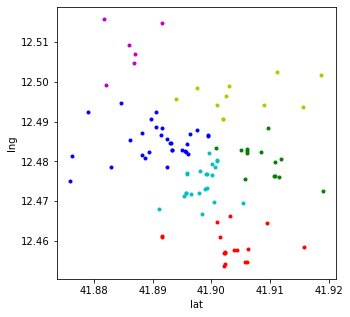

In [85]:
ptsymb = np.array(['b.','r.','m.','g.','c.','y.'])
plt.figure(figsize=(5,5))
plt.ylabel('lng')
plt.xlabel('lat')
for i in range(n):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.lat[cluster].values,X.lng[cluster].values,ptsymb[i])
plt.show()

Now we will mark points on the map of Rome

In [102]:
X['cluster'] = kmeans.fit_predict(X)
#adding a column with the cluster number
X

lat        lng  cluster
0   41.895747  12.482446        3
1   41.895042  12.482880        3
2   41.899133  12.476805        0
3   41.895440  12.482687        3
4   41.895816  12.484276        3
..        ...        ...      ...
95  41.906088  12.483215        2
96  41.895702  12.472020        0
97  41.884662  12.494715        3
98  41.906046  12.482057        2
99  41.885977  12.509265        5

[100 rows x 3 columns]

In [87]:
Y = X.assign(name = dataframe.name)
#adding a column with the name of the object
Y

lat        lng  cluster                                 name
0   41.895747  12.482446        0                       Piazza Venezia
1   41.895042  12.482880        0                  Altare della Patria
2   41.899133  12.476805        4                             Pantheon
3   41.895440  12.482687        0                           Vittoriano
4   41.895816  12.484276        0  Zuil van Trajanus (Colonna Traiana)
..        ...        ...      ...                                  ...
95  41.906088  12.483215        3                 Obelisco Sallustiano
96  41.895702  12.472020        4                      Campo de' Fiori
97  41.884662  12.494715        0                    Villa Celimontana
98  41.906046  12.482057        3                     Piazza di Spagna
99  41.885977  12.509265        2         Piazza di Porta San Giovanni

[100 rows x 4 columns]

In [88]:
#create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=12)

#set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Y['lat'], Y['lng'], Y['name'], Y['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Cluster 1

In [90]:
Y.loc[Y['cluster'] == 0, Y.columns[[3]+[0]+[1]]]

name        lat        lng
0                                      Piazza Venezia  41.895747  12.482446
1                                 Altare della Patria  41.895042  12.482880
3                                          Vittoriano  41.895440  12.482687
4                 Zuil van Trajanus (Colonna Traiana)  41.895816  12.484276
5                                        Arco di Tito  41.890649  12.488537
6                                            Colosseo  41.890633  12.492378
7                                     Palazzo Venezia  41.895965  12.481852
9                                       Arco di Giano  41.889333  12.482345
10                            Arco di Settimio Severo  41.892894  12.484658
12                                    Marcus Aurelius  41.893367  12.482793
14                                 Arco di Costantino  41.889755  12.490618
15                                Torre delle Milizie  41.896329  12.486965
16                                           Palatino  41.888234  12.487209
22                         Tempio di Ercole Vincitore  41.888717  12.480796
23                              Palazzo del Quirinale  41.899409  12.486446
25                                      Circo Massimo  41.886217  12.485243
31                    Palazzo Pallavicini-Rospigliosi  41.897475  12.487833
33                                        Foro Romano  41.892393  12.485503
38                                  Portico d'Ottavia  41.892382  12.478500
44                                    Piramide Cestia  41.876354  12.481421
45                                 Obelisco Quirinale  41.899408  12.486508
48                                  Carcere Mamertino  41.893096  12.484725
49                                 Bocca della Verità  41.888257  12.481542
55                                    Monte Testaccio  41.875912  12.475163
61                              Basilica di Massenzio  41.891624  12.488472
63  Atrium Vestae | House of the Vestal Virgins (C...  41.891430  12.486590
70                                 Terme di Caracalla  41.878990  12.492443
73                             Piazza del Campidoglio  41.893321  12.482956
94                      Piazza dei Cavalieri di Malta  41.882908  12.478564
97                                  Villa Celimontana  41.884662  12.494715

Cluster 2

In [91]:
Y.loc[Y['cluster'] == 1, Y.columns[[3]+[0]+[1]]]

name        lat        lng
32                               Obelisco Vaticano  41.902233  12.457262
35                      Ponte Vittorio Emanuele II  41.900958  12.464652
36                          Terrazza del Gianicolo  41.891556  12.461348
52                                 Porta Sant'Anna  41.903878  12.457811
54                           Monumento a Garibaldi  41.891541  12.461080
56                              Castel Sant'Angelo  41.903131  12.466328
57                           Pietà di Michelangelo  41.902357  12.454290
67  Basilica di San Pietro (Basilica Sancti Petri)  41.902133  12.453582
75               Chiesa di Santo Spirito in Sassia  41.901377  12.460917
76                         Piazza del Risorgimento  41.906182  12.457938
79               Tomba del Beato Giovanni Paolo II  41.902194  12.457060
80                                 Sfera con Sfera  41.905732  12.454595
83                        Quartiere della Vittoria  41.915741  12.458521
84                               Piazza San Pietro  41.902225  12.457026
86                                  Porta Angelica  41.904301  12.457822
89                             Cortile della Pigna  41.906022  12.454618
91                              Piazza dei Quiriti  41.909380  12.464419

Cluster 3

In [92]:
Y.loc[Y['cluster'] == 2, Y.columns[[3]+[0]+[1]]]

name        lat        lng
51          Obelisco Lateranense  41.886876  12.504656
66                   Scala Santa  41.887042  12.507036
68                Porta Maggiore  41.891530  12.514794
88         Piazza dei Re di Roma  41.881732  12.515683
92             Piazzale Metronio  41.882147  12.499062
99  Piazza di Porta San Giovanni  41.885977  12.509265

Cluster 4

In [93]:
Y.loc[Y['cluster'] == 3, Y.columns[[3]+[0]+[1]]]

name        lat        lng
8             Trevi-fontein (Fontana di Trevi)  41.900844  12.483252
24                     Colonna dell'Immacolata  41.905000  12.482881
26              Scalinata di Trinità dei Monti  41.905974  12.482647
27                        Museo dell'Ara Pacis  41.905744  12.475521
28                           Obelisco Flaminio  41.910751  12.476385
41  Villa Medici - Accademia di Francia a Roma  41.908346  12.482405
43                            Porta del Popolo  41.911541  12.476027
78                           Piazza del Popolo  41.910683  12.476342
81                      Viale delle Belle Arti  41.919000  12.472664
82                              Porta Pinciana  41.909572  12.488381
85                             Obelisco Pincio  41.910853  12.479761
90                              Idrocronometro  41.911763  12.480692
95                        Obelisco Sallustiano  41.906088  12.483215
98                            Piazza di Spagna  41.906046  12.482057

Cluster 5

In [94]:
Y.loc[Y['cluster'] == 4, Y.columns[[3]+[0]+[1]]]

name        lat        lng
2                              Pantheon  41.899133  12.476805
11  Elefantino e Obelisco della Minerva  41.898041  12.477461
13             Colonna di Marco Aurelio  41.900930  12.480185
17             Largo di Torre Argentina  41.895797  12.476852
18                        Piazza Navona  41.899239  12.473184
19                    Tempio di Adriano  41.900029  12.479352
20                       Piazza Colonna  41.901028  12.480237
29               Piazza della Maddalena  41.900130  12.476583
34            Obelisco di Monte Citorio  41.900611  12.478559
37              Santa Maria della Scala  41.891161  12.468144
39                        Piazza Cavour  41.905422  12.469573
40                    Obelisco Agonalis  41.898899  12.473165
42                     Via dei Coronari  41.900488  12.469740
60                Via dei Banchi Vecchi  41.898436  12.466881
62                       Piazza Farnese  41.895261  12.471209
64                           Area Sacra  41.895805  12.477062
65                     Galleria Sciarra  41.899537  12.482200
71           Monumento a Giordano Bruno  41.895706  12.472114
74            Palazzo della Cancelleria  41.896568  12.471764
87                 Piazza della Rotonda  41.899253  12.476779
93                   Piazza di Pasquino  41.897809  12.472157
96                      Campo de' Fiori  41.895702  12.472020

Cluster 6

In [95]:
Y.loc[Y['cluster'] == 5, Y.columns[[3]+[0]+[1]]]

name        lat        lng
21                Le Quattro Fontane  41.901968  12.490730
30           Piazza della Repubblica  41.902422  12.496367
46                 Museo Boncompagni  41.908920  12.494189
47            S. Paolo Entro le Mura  41.901004  12.494267
50                       Domus Aurea  41.894033  12.495643
53                         Porta Pia  41.911100  12.502566
58        Ingresso Portale del Leone  41.915611  12.493687
59                 Quartiere Coppedé  41.918617  12.501755
69  Basilica di Santa Maria Maggiore  41.897629  12.498429
72         Via delle Quattro Fontane  41.902050  12.490605
77  Museo delle Terme di Diocleziano  41.902912  12.498882